# TM10007 Assignment Head and Neck cancer Radiomics

Marie-Claire Doornbos ()
Julia Holdorp (4561651)
Quinten Mank (4336615)
Ylva Weeda (4556038)

 

In [16]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

## Importing Modules

In [4]:
import pandas as pd
import numpy as np
import statistics
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import LeaveOneOut, RepeatedStratifiedKFold, StratifiedKFold 
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import auc, roc_curve, accuracy_score, confusion_matrix, roc_auc_score
from scipy import interp
from scipy.stats import randint
from pprint import pprint



## 1. Data and preprocessing
The Head and Neck cancer dataset is loaded into the script. If the dataset contains any missing values or NaN, the missing value is replaced with the mean of the feature in question. Eventually, the data is split into feature values and labels (high risk (1) or low risk (0)). The amount of high-risk and low-risk patients is printed as an output. 


1.1 Load data

In [5]:

from hn.load_data import load_data

def load_check_data():
    '''
    Check if the datafile exists and is valid before reading
    '''
    # Check whether datafile exists
    try:
        data = load_data()
        print(f'The number of samples: {len(data.index)}')
        print(f'The number of columns: {len(data.columns)}')
    except FileNotFoundError:
        return print("The csv datafile does not exist"), sys.exit()
    except pd.errors.ParserError:
        return print('The csv datafile is not a proper csv format.'
                     'Please provide a data file in csv format.'), sys.exit()
    # Check whether data is missing.
    # If any datapoints are missing or NaN, these empty cells are replaced with the average 
    # of that feature.
    if data.isnull().values.any():
        column_mean = data.mean()
        data = data.fillna(column_mean)
        print('In the csv data file, some values are missing or NaN.'
              ' These missing values are replaced by the mean of that feature.')
    return data
data = load_check_data()

The number of samples: 113
The number of columns: 160


1.2 Extract feature values and labels

In [6]:
# Features from data
features = data.loc[:, data.columns != 'label'].values

# Labels from data
labels = data.loc[:,['label']].values
#low risk patients receive the label 0 and high risk the label 1
labels = [item if item!='T12' else 0 for item in labels]
labels = [item if item!='T34' else 1 for item in labels]
labels = np.array(labels)
#number of high and low risk patients is printed to the terminal
print(f'Number of high risk patients: {np.count_nonzero(labels)}') 
print(f'Number of low risk patients: {len(labels) - np.count_nonzero(labels)}')

Number of high risk patients: 55
Number of low risk patients: 58


1.3 Splitting the data in training and test

In [65]:
def split_sets(x, y):
    """
    Splits the features and labels into a training set (80%) and test set (20%)
    """
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=None)
    
    for train_index, test_index in crss_val.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test = y[train_index], y[test_index]

        scaler = StandardScaler()
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)
       
       
#x_train, x_test, y_train, y_test = split_sets(features, labels)


# 2. Feature selection
Two different feature selection/extraction tools will be used. Firstly, least absolute shrinkage and selection operator (LASSO) will be executed to find the most distinctive and informative features for analysis. Later on, a principal component analysis (PCA) is executed while training the model. The amount of principal components were calculated beforehand. In the end, the two different methods will be compared to see which method works best!  




2.1 LASSO 

2.2 Principal components



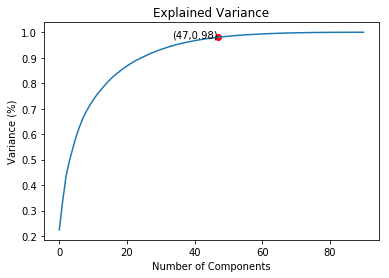

In [66]:
pca = PCA().fit(x_train)
plt.figure()
plt.scatter(47, 0.98, color='r')
plt.text(47, 0.98, '(47,0.98)', horizontalalignment='right')
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Explained Variance')
plt.show()
# 47 components for principal component analysis 

# 3. Hyperparameters optimalization and validation
In this part, the data is seperated into a training and a test set. A standard scaler is used to standardize the training set. The training set is fitted and transformed, while the test set is only transformed. (never touch your test set!!) The following classifiers will be used: Logistic Regression, KNN, Random Forest and SVM. In order to find the optimal hyperparameters, a random grid search is executed. The optimal parameters are printed to the terminal and are used for validation. Two different validation methods were used: Leave one out cross validation and repeated KFold cross validation (5 folds and .. repeats). Inside this cross validation, the training set is once again splitted into a training set and a validation set. The performance is determined by the accuracy, sensitivity, specificity and auc. Also, ROC plots are plotted for the different classifiers.  
- ook nog even de learning curve in verwerken! 

3.1 Getting the hyperparameters for every classifier

In [83]:
def get_hyperparameters(x, y):
    """ 
    Random Search for Hyperparameters classifiers
    """

    clsfs = [KNeighborsClassifier(), RandomForestClassifier(bootstrap=True, random_state=None), SVC(probability=True)]
    param_distributions = [{"n_neighbors": randint(1, 20)}, {"n_estimators": randint(1, 200),
                            "max_features": randint(5, 30),
                            "max_depth": randint(2, 18),
                            "min_samples_leaf": randint(1, 17)},{"C": randint(0.1, 100),
                            "gamma": ['auto','scale'],
                            "kernel": ['rbf','poly','sigmoid','linear']}]

    hyperparameters_clsfs = []
    clf_selected = [] 
    for clf, param_dist in zip(clsfs, param_distributions):
        random_search = RandomizedSearchCV(clf, param_distributions=param_dist, n_iter=5, cv=5, n_jobs=-1)
        model = random_search.fit(x, y)
        parameters = model.best_estimator_.get_params()
        clf_selected.append(model.best_estimator_)
        #pprint(parameters)
        hyperparameters_clsfs.append(parameters)
        values = pd.DataFrame(model.cv_results_)
        #pprint(values)

    return clf_selected


#Randomized search in cross validation
crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=None) 

for train_index, test_index in crss_val.split(features, labels):
    x_train, x_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]

    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    pca = PCA(n_components=47)
    pca.fit(x_train)
    x_train = pca.transform(x_train)
    x_val = pca.transform(x_test)

    selection = get_hyperparameters(x_train, y_train)


    predict_proba = [] 
    predict_labels = [] 

    for clf in selection:
        clf.fit(x_train,y_train) 
        clf_predicted=clf.predict(x_test)
        predict_labels.append(clf_predicted)
        predict = clf.predict_proba(x_test)[:,1]
        predict_proba.append(predict)
    print(predict_proba)



    


C:\Users\ylvaw\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ylvaw\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)
C:\Users\ylvaw\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


ValueError: query data dimension must match training data dimension

3.2 Learning curve

3.3 Leave one Out cross validation on training and validation set - PCA
- Sensitivity, specificity, auc en accuracy even fixen in 1 boxplot
- Alle ROC's in 1 plot ipv los
 

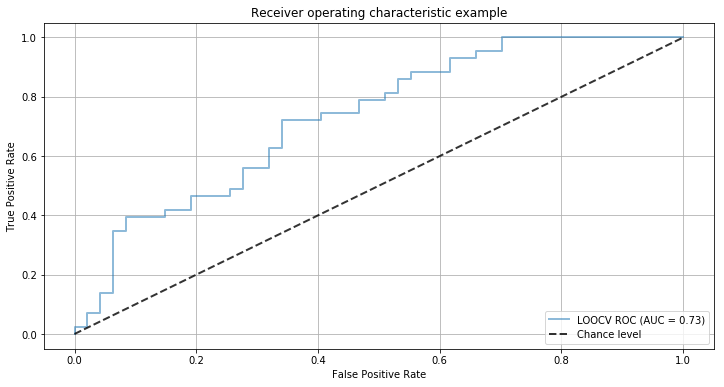

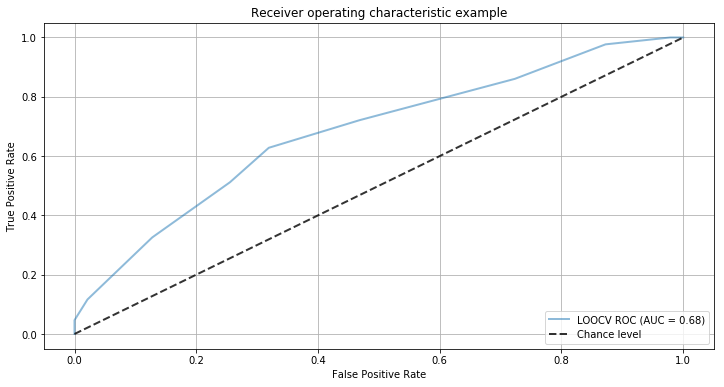

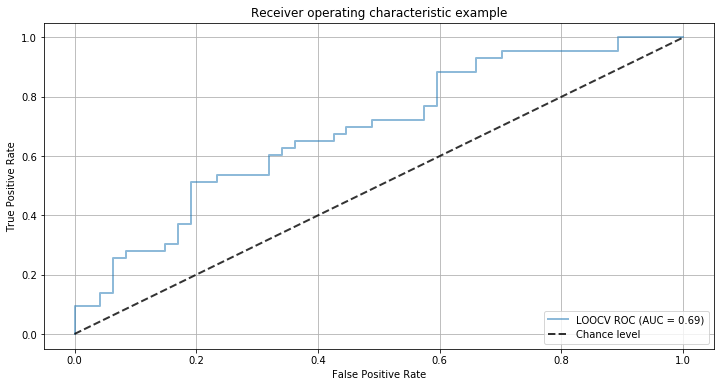

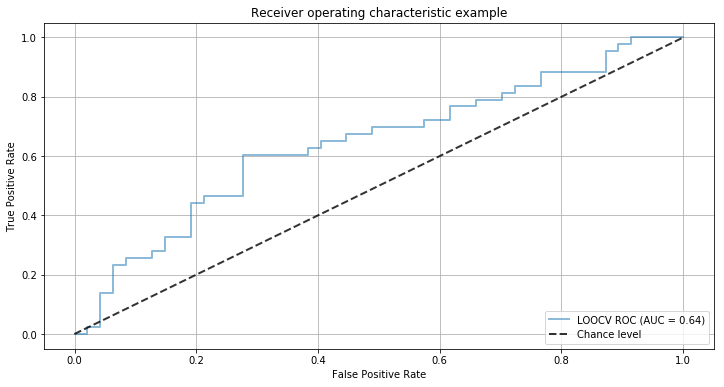

In [51]:

def leave_one_out_pca(x,y, hyperparameters, clf):
    """  
    Leave One Out Cross Validation using Logistic Regression as a classifier
    """
    loo = LeaveOneOut()
    loo.get_n_splits(x,y)

    accuracies = []
    auc_scores = []
    specificities = []
    sensitivities = []

    predict_labels = [] 
    predict_proba =[]
    y_val_total = []

    for train_index, val_index in loo.split(x,y):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val= y[train_index], y[val_index]

        if min(x_train.shape[0], x_train.shape[1]) < 47:
            print('Not enough input values for PCA with 70 components')
            sys.exit()
        else:
            pca = PCA(n_components=47)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_val = pca.transform(x_val)

            clf.fit(x_train,y_train) 
            clf_predicted=clf.predict(x_val)
            predict_labels.append(clf_predicted)
            predict = clf.predict_proba(x_val)[:,1]
            predict_proba.append(predict)
            y_val_total.append(y_val)
    
    performance_scores = pd.DataFrame() 
    predict_labels = np.array(predict_labels)
    auc_scores.append(roc_auc_score(y_val_total, predict_labels))
    conf_mat = confusion_matrix(y_val_total, predict_labels)
    total = sum(sum(conf_mat))
    accuracies.append((conf_mat[0, 0]+conf_mat[1, 1])/total)
    sensitivities.append(conf_mat[0, 0]/(conf_mat[0, 0]+conf_mat[0, 1]))
    specificities.append(conf_mat[1, 1]/(conf_mat[1, 0]+conf_mat[1, 1]))
    performance_scores['Accuracy'] = accuracies
    performance_scores['AUC'] = auc_scores
    performance_scores['Sensitivity'] = sensitivities
    performance_scores['Specificity'] = specificities

    predict_proba = np.array(predict_proba)
    fpr, tpr, __ = roc_curve(y_val_total, predict_proba)
    roc_auc = auc(fpr, tpr)
    plt.figure(1, figsize=(12,6))
    plt.plot(fpr, tpr, lw=2, alpha=0.5, label='LOOCV ROC (AUC = %0.2f)' % (roc_auc))
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=.8)
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    return performance_scores

performance_clf = []
clsfs = [LogisticRegression(), KNeighborsClassifier(n_neighbors=hyperparameters[0].get('n_neighbors')), RandomForestClassifier(bootstrap=True, max_depth=hyperparameters[1].get('max_depth'), max_features=hyperparameters[1].get('max_features'), min_samples_leaf=hyperparameters[1].get('min_samples_leaf'), n_estimators=hyperparameters[1].get('n_estimators'), random_state=None), SVC(C=hyperparameters[2].get("C"), gamma=hyperparameters[2].get("gamma"), kernel=hyperparameters[2].get("kernel"), probability=True)]
clsfs_names =['Logistic Regression', 'kNN', 'Random Forest', 'SVM']

for clf in clsfs:
    performances = leave_one_out_pca(x_train, y_train, hyperparameters, clf) 






3.4 Repeated KFold cross validation on training and validation set - PCA
- ROC's in 1 grafiek
- boxplots in 1 plot
- titels van de ROC curves aanpassen

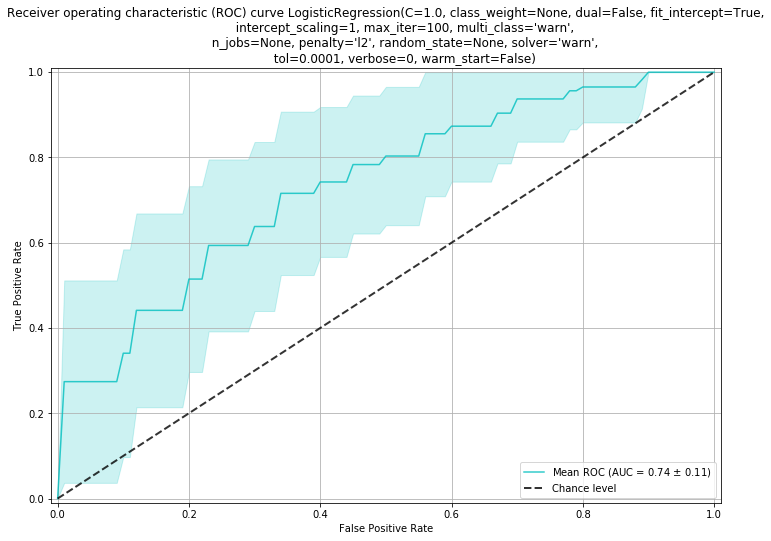

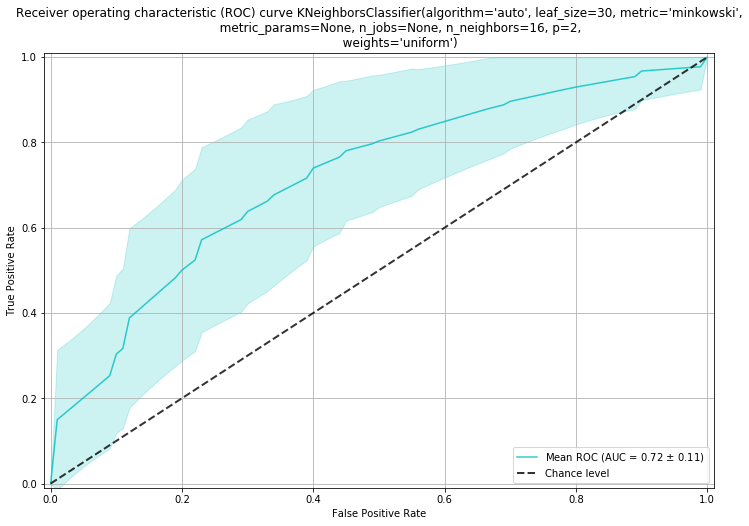

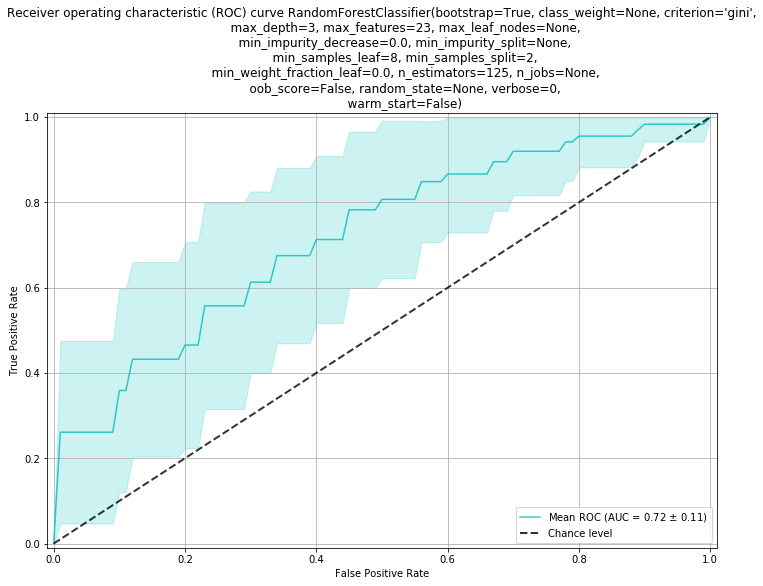

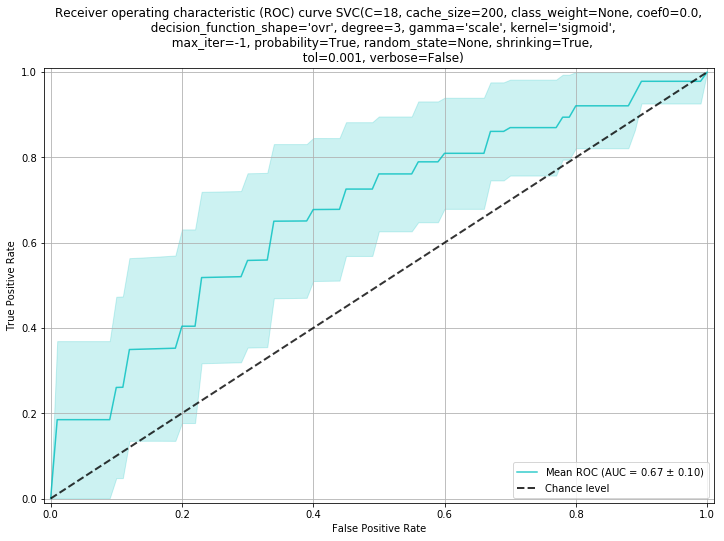

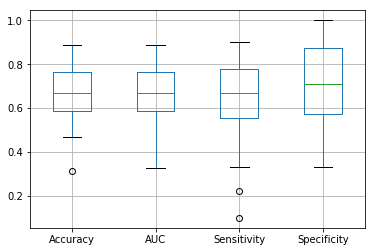

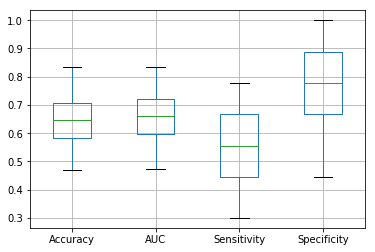

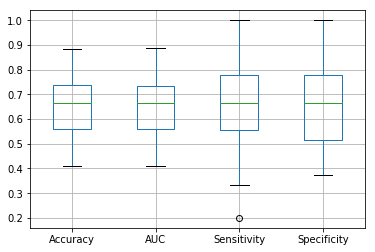

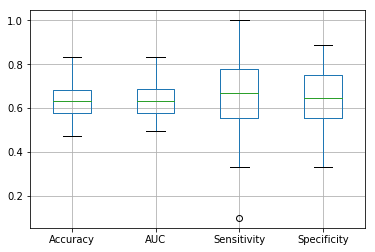

In [50]:
def cross_val_scores_pca(x, y, hyperparameters, clf):
    '''
    Cross validation using a Logistic Regression classifier (5 folds)
    '''
    
    crss_val = RepeatedStratifiedKFold(n_splits=5, n_repeats=10, random_state=None)
    crss_val.get_n_splits(x, y)

    accuracies = []
    auc_scores = []
    specificities = []
    sensitivities = []
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)

    for train_index, val_index in crss_val.split(x, y):
        x_train, x_val = x[train_index], x[val_index]
        y_train, y_val = y[train_index], y[val_index]

        if min(x_train.shape[0], x_train.shape[1]) < 47:
            print('Not enough input values for PCA with 70 components')
            sys.exit()

        else:
            pca = PCA(n_components=47)
            pca.fit(x_train)
            x_train = pca.transform(x_train)
            x_val = pca.transform(x_val)
            clf.fit(x_train, y_train)
            prediction = clf.predict(x_val)

            performance_scores = pd.DataFrame()                  
            auc_scores.append(roc_auc_score(y_val, prediction))
            conf_mat = confusion_matrix(y_val, prediction)
            total = sum(sum(conf_mat))
            accuracies.append((conf_mat[0, 0]+conf_mat[1, 1])/total)
            sensitivities.append(conf_mat[0, 0]/(conf_mat[0, 0]+conf_mat[0, 1]))
            specificities.append(conf_mat[1, 1]/(conf_mat[1, 0]+conf_mat[1, 1]))
            performance_scores['Accuracy'] = accuracies
            performance_scores['AUC'] = auc_scores
            performance_scores['Sensitivity'] = sensitivities
            performance_scores['Specificity'] = specificities

            predicted_probas = clf.predict_proba(x_val)[:, 1]
            fpr, tpr, _ = roc_curve(y_val, predicted_probas)
            roc_auc = auc(fpr, tpr)
            aucs.append(roc_auc)
            tpr = interp(base_fpr, fpr, tpr)
            tpr[0] = 0.0
            tprs.append(tpr)
 
    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)

    mean_auc = auc(base_fpr, mean_tprs)
    std_auc = np.std(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std
    plt.figure(figsize=(12, 8))
    plt.plot(base_fpr, mean_tprs, 'c', alpha=0.8, label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),)
    plt.fill_between(base_fpr, tprs_lower, tprs_upper, color='c', alpha=0.2)
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='k', label='Chance level', alpha=0.8)
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc="lower right")
    plt.title(f'Receiver operating characteristic (ROC) curve {clf}')
    plt.grid()
    plt.show()

    return performance_scores


performance_clf = []
clsfs = [LogisticRegression(), KNeighborsClassifier(n_neighbors=hyperparameters[0].get('n_neighbors')), RandomForestClassifier(bootstrap=True, max_depth=hyperparameters[1].get('max_depth'), max_features=hyperparameters[1].get('max_features'), min_samples_leaf=hyperparameters[1].get('min_samples_leaf'), n_estimators=hyperparameters[1].get('n_estimators'), random_state=None), SVC(C=hyperparameters[2].get("C"), gamma=hyperparameters[2].get("gamma"), kernel=hyperparameters[2].get("kernel"), probability=True)]
clsfs_names =['Logistic Regression', 'kNN', 'Random Forest', 'SVM']

for clf in clsfs:
    performances = cross_val_scores_pca(x_train, y_train, hyperparameters, clf) 
    performance_clf.append(performances)

for item in performance_clf: 
    plt.figure()
    item.boxplot()
    plt.show()

3.5 Repeated KFold cross validation on training and validation set - LASSO

3.6 LASSO vs. PCA
- Analyse whether LASSO or PCA works better! 

3.5 Hyperparameters optimalisation vs. no optimalisation
- Analyse whether the hyperparameter optimalisation works better! 

## 6. Evaluation
To evaluate the machine learning algoritm for the prediction of the T-score in head and neck cancer patients, different outcome measures are used. The area under the ROC curve is plotted and also accuracy, sensitivity and specificity are computed using the confusion matrix. The evalution is only executed on the test set to see whether an accuracy of 70% is achieved or not. 

--> box plots


In [ ]:
def model_performance(x, y, hyperparameters, clf):

    ss = StratifiedShuffleSplit(n_splits=100, test_size=0.5)
    ss.get_n_splits(x, y)

    performances = []

    for train_index, test_index in ss.split(x, y):
        x_train, x_test = x[train_index], x[test_index]
        y_train, y_test= y[train_index], y[test_index]

        clf.fit(x_train,y_train) 

        prediction = clf.predict(x_test)
        #en hier nog alles voor de ROC curves & boxplots etc. 
